# An implementation of the fringe reduction algoirthm for absorption images of ultracold clouds
$\textit{Warning: GitHub's rendering of Latex in iPython notebook is still a bit buggy}$.

### Introduction

In absorption imaging, a probe beam is shone on the atom cloud and a fraction of that probe light is absorbed.  This absorption is describe by the Beer-Lambert law, 

$$I(x,y)=I_0\exp[-OD(x,y)]$$. 

$OD$ is the optical density of the cloud, which is directly proportional to the density of atoms, $OD\propto n(x,y)$, which is the quantity of interest.  

To extract the $OD$, two images are taken: an image of the atom cloud (abs) which yields $I(x,y)$, and a reference image without the atom cloud (ref) which yields $I_0$.  The $OD$ can then be obtained, 

$$OD(x,y)=-\log[I(x,y)/I_0]=-\log\left[\frac{I_{abs}}{I_{ref}}\right]$$


In the ideal case, we can decompose the images as 

$$I_{abs} = signal\times background$$
$$I_{ref} = background$$

and so $OD(x,y)=-\log\left[\frac{signal\times background}{background}\right]=-\log\left[signal\right]$ as desired.

However, in practice the background between the absorption and reference images can shift, creating false signals $OD(x,y)=-\log\left[\frac{signal\times background_{abs}}{background_{ref}}\right]=-\log\left[signal+\epsilon\right]$.  Here, $\epsilon$ represents the $noise$ in the signal.

$\textit{Removing the noise is the goal of this algorithm}$.

In general, there can be $\#\, pixels ^{\#\,bits\,per\,pixel}$ combinations of different background images -- a complete basis of possible noise vectors.  However, if we know something about the type of fluctuations leading to $\epsilon$, we can dramatically reduce the space of noise vectors.

The shift in the background, $\epsilon$, occurs due to technical reasons.  It is not uncommon to have high spatial frequency interference fringes in the probe due to imperfections in the imaging system.  In addition, there may be vibrations in the system, which then displace these fringes.  Thus $\epsilon$ takes on the form of the interference fringes in the probe.  These fringes are large scale, and high-frequency.  The space of noise vectors is thus spanned by the different fringe patterns and their phase (modulo 2$\pi$),
$$noise=\sum_{i,j} A_i\cos(k_ir+\phi_j)$$

This code implements an alogrithm to first identify the noise eigenvectors, and second engineer a new reference image to match the background of the signal.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy import misc
import scipy.ndimage as ndimage
import glob
import SchmidtDecomp as sd
%matplotlib inline

### Load images into memory

In [2]:
# Original source - E:\ARCHIVE\Research\Projects\BEC\2012 08 28 - effective mass
root = 'C:\\Users\\Rockson3\\Jupyter Projects\\IPP'
fnamesRef= glob.glob(root+'\data\*Ref.tif')
fnamesAbs = glob.glob(root+'\data\*Abs.tif')

In [3]:
imgRef=np.zeros((len(fnamesAbs),255, 256))
imgAbs=np.zeros((len(fnamesAbs),255, 256))
for i in range(len(fnamesAbs)):
    imgRef[i,:,:] = misc.imread(fnamesRef[i])
    imgAbs[i,:,:] = misc.imread(fnamesAbs[i])    

### Look at an individual image
Here I show an example pair of raw absorption and reference images, and the resulting $OD$ signal.  In the raw absorption and reference images, the red indicates high probe light intensity and the blue indicates low intensity.  The signal we are searching for is revealed in the optical density image, where reds indicate high atomic density and blues low density.  In the data set used here, the signal is a series of 3-4 atom clouds arranged horizontally in a line.  This is a characteristic signal for atoms which have been loaded into an $optical$ $lattice$.  

This data is part of a much larger data set from the University of Toronto, where we studied the dynamics of quantum transport in a periodic medium.  The results are published in Physical Review Letters [R. Chang et al, Phys. Rev. Lett. 112, 170404 (2014)], and is freely available on the arXiv
http://arxiv.org/abs/1303.1139.  There is also vulgarized description of our work published in Phys.org
http://phys.org/news/2014-05-physicists-onset-effective-mass.html

From the raw images, the structure present in the probe is evident.  There is both large scale and small scale structure, respectively low and high frequency spatial structures.  Since the relative shifts between images is typically small, it is the high frequency structure that shows up as $noise$ in the $OD$ image.  

(-0.5, 255.5, 254.5, -0.5)

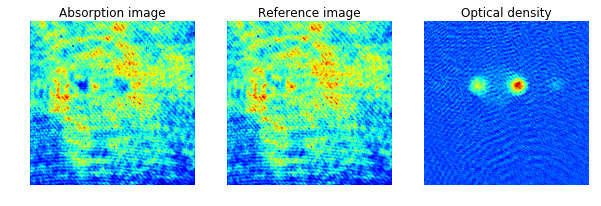

In [4]:
# pick a random image
i = 3 
img    = -np.log(imgAbs[i,:,:]/imgRef[i,:,:])

# plot
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(131)
ax.imshow(imgAbs[i,:,:])
plt.title('Absorption image')
ax.axis('off')
ax = fig.add_subplot(132)
ax.imshow(imgRef[i,:,:])
plt.title('Reference image')
ax.axis('off')
ax = fig.add_subplot(133)
ax.imshow(img)
plt.title('Optical density')
ax.axis('off')

### Generate basis of noise vectors
The basis of noise vectors is obtained through Schmidt-Decomposition of the reference images.  Because of the structure present in the noise, the space of noise vectors is significantly reduced and a finite number of reference images may be used to describe the typical noise present in a given data set.  In this example there are 17 absorption / reference image pairs, leading to the generation of 17 noise vectors.

The process of Schmidt decomposition is used to identify a basis of noise vectors, $\vec{B}$.  These basis vectors are orthogonal (no overlap, $\vec{B}_i\cdot\vec{B}_j=0$) by construction.  

$$\vec{B}_1 =\vec{R}_1$$
$$\vec{B}_2=\vec{R}_2 -(\vec{R}_2 \cdot \vec{B}_1) \,\vec{B}_1$$

$$\vdots$$

In general, we can write
$$\vec{B}_i=\vec{R}_i - \sum_{j<i}(\vec{R}_i \cdot \vec{B}_j)\, \vec{B}_j$$

In [5]:
refBasis=sd.genBasis(imgRef)

### Plot generated noise vectors 
Below I plot the results of the Schmidt decomposition of the 17 reference images.  On the left are the generated noise vectors.  On the right are their corresponding 2D fourier transforms (really the power spectrum of the spatial noise).  

The first image essentially represents the low spatial frequency component of the noise.  This is represented in the frequency spectrum by a near delta function at the center ($k_x=k_y=0$).  The subsequent images contain higher frequency noise arising from the shifting fringe pattern.  It's interesting note the presence of various noise structures -- linear fringes (images 7 and 8) and radial fringes (images 2 and 4), each clearly exhibiting different features in their respective frequency spectra.

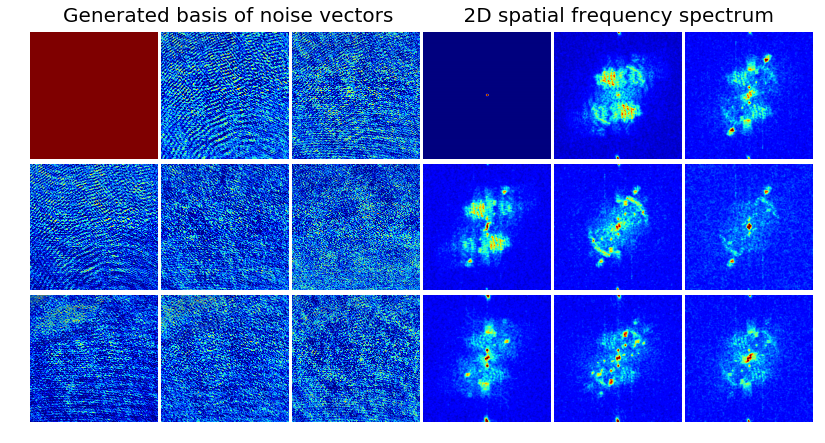

In [6]:
fig = plt.figure(figsize=(14,7))
gs1 = gridspec.GridSpec(3,6)
gs1.update(wspace=0.03, hspace=0.03) # set the spacing between axes. 
j=0
#for i in range(0,len(refBasis)):     
for i in range(0,9): # only show the first 10    
    ax = plt.subplot(gs1[j+i])
    ax.imshow(refBasis[i,:,:],vmin=np.min(refBasis[i,:,:])*0.2,vmax=np.max(refBasis[i,:,:])*0.9)
    ax.axis('off')
    
    ax = plt.subplot(gs1[j+i+3])
    img=np.abs(np.fft.fftshift(np.fft.fft2(refBasis[i,:,:])))    
    imgSmooth = ndimage.gaussian_filter(img, sigma=1, order=0)
    #ax.imshow(imgSmooth,interpolation='gaussian',vmin=np.min(imgSmooth),vmax=np.max(imgSmooth))
    ax.imshow(imgSmooth,interpolation='gaussian',vmin=0,vmax=5)
    ax.axis('off')
    
    if np.mod(i,3)==2:
        j=j+3    
plt.suptitle('Generated basis of noise vectors           2D spatial frequency spectrum',x=0.51,y=0.95,fontsize=20)

### Generate idealized reference image for each absorption image
Using the basis of noise vectors $\vec{B}$, we can then generate an idealized reference image $\vec{R}^\prime$ to match the absorption image $\vec{A}$. In other words, we decompose the fringe pattern present in the absorption images into the basis of noise vectors.

$$ \vec{R}^\prime_1 = (\vec{A}_1\cdot\vec{B}_1)\,\vec{B}_1 +(\vec{A}_1\cdot\vec{B}_2)\,\vec{B}_2 +(\vec{A}_1\cdot\vec{B}_3)\,\vec{B}_3 \,\,...$$

In general we write
$$ \vec{R}^\prime_i = \sum_{j}(\vec{A}_i\cdot\vec{B}_j)\,\vec{B}_j$$

In an ideal situation, we should block out the signal (the atom multiple atom clouds arranged in a line).  In practice, we have found it hardly changes the resulting signal since the information contained in the noise vectors represents large scale, high spatial frequency noise, whereas the signal is localized and typically low-frequency.


In [7]:
modRef=sd.genReference(imgAbs, refBasis)    

### Plot and compare orignal signal and matched signal
On the left I plot the original optical density signal, generated from the original absorption / reference image pair.  On the right I plot the new signal, generated from the absorption / matched reference pair.  All images are plotted on the same color scale.  It is clear that the algorithm has successfully removed much of the noise in the images, making for a much cleaner signal.  Low optical density signals, previously hidden by the noise, are now much clearer.  For example image 5 shows the clear emergence of a scattering halo between the two central atom clouds.

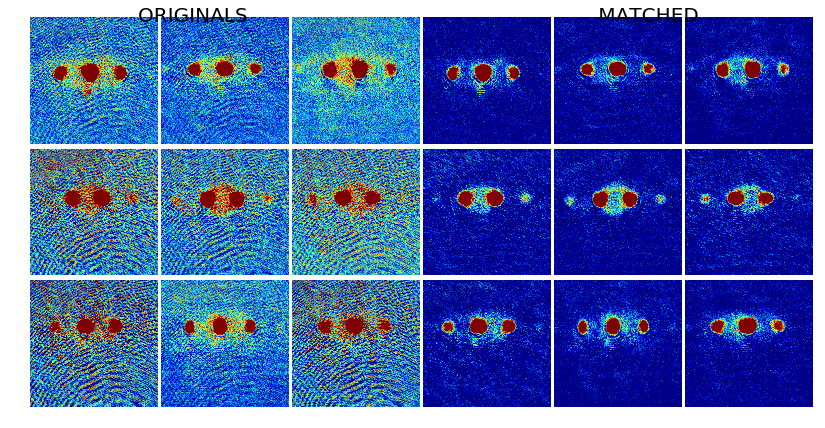

In [11]:
fig = plt.figure(figsize=(14,7))
gs1 = gridspec.GridSpec(3,6)
gs1.update(wspace=0.03, hspace=0.03) # set the spacing between axes. 
j=0
#for i in range(len(imgAbs)):    
for i in range(9):    
    img    = -np.log(imgAbs[i,:,:]/imgRef[i,:,:])    
    ax = plt.subplot(gs1[j+i])
    ax.imshow(img, vmin=0, vmax=0.001)
    ax.axis('off')
    imgMod = -np.log(imgAbs[i,:,:]/modRef[i,:,:])    
    ax = plt.subplot(gs1[j+i+3])
    ax.imshow(imgMod, vmin=0, vmax=0.001)
    ax.axis('off')    
    if np.mod(i,3)==2:
        j=j+3
plt.suptitle('ORIGINALS                                                       MATCHED',x=0.51,y=0.92,fontsize=20)    
plt.show()

### Outlook
Further improvement on the matching can be obtained by masking out the atom signal in the projection step of the idealized reference image generation.  Also, including more reference images may improve the range of noise features captured by the basis of noise vectors.

Some features to add to notes:
- present 1D cuts of data
- quantify noise level in orignals and matched images 
    - calculate an averaged standard deviation
    - generate a radial frequency spectrum ($r^2=x^2+y^2$) and overlay the resulting 1D profiles
- present signals for increasing number of basis noise vectors